# Image classification with CNNs and small augmented datasets

In [3]:
! pip install keras-tqdm

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import string
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, transform_matrix_offset_center, img_to_array, ImageDataGenerator)
from keras import backend as K
from keras.datasets import fashion_mnist

# nice progress bars for learning
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [5]:
# set consistent random seed
random_seed = 2018
np.random.seed(random_seed)  
tf.set_random_seed(random_seed)

## Intro
Machine learning requires lots of data. However, can you get some meaningful results from just a hundred examples? And if so, how do you do that?

The easiest way to train your machine learning algorithm on a small dataset, is to make the dataset bigger. This might sound contraditory, but in this post I will show you a simple way to augment your small image datasets with the help of [Keras](). 


## Dataset
One of the classic examples in image recognition is the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). It consists of a collection of 70,000 grayscale images with a fixed size of 28x28 pixels. Each image shows a handwritten digit between 0 and 9. 

In this post, we will use Zalandos [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This dataset is a direct replacement for the regular MNIST dataset but offers a bigger challenge than it's predeccessor for which error rates below one percent are now common. The 70,000 images in the new dataset have the same dimensions and are also divided into ten classes. Instead of handwritten digits, given the fact that the dataset comes from Zalando, you may already have guessed that the images depicts images of clothes and shoes. 

Zalando introduced this dataset in a [2017 paper](https://arxiv.org/abs/1708.07747) to offer an alternative to the [overused](https://www.kaggle.com/benhamner/popular-datasets-over-time/code) MNIST dataset.

Since `Fashion-MNIST` conveniently has the same dimensions as regular `MNIST`, it was already integrated in various machine learning libraries like Tensorflow or Pytorch.

So lets get started!

### Importing, normalizing, visualizing...

First we let Keras download the dataset for us.

In [6]:
(raw_train_data, raw_train_labels), (raw_test_data, raw_test_labels) = fashion_mnist.load_data()

In [7]:
# 60000 training images with 28x28 pixels
print(np.shape(raw_train_data))
# 60000 labels
print(np.shape(raw_train_labels))

# 10000 test images with 28x28 pixels
print(np.shape(raw_test_data))
# 10000 labels
print(np.shape(raw_test_labels))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


The images consist of grayscale values between `0.0` and `255.0`.
We normalize them by dividing the whole data arrays by `255.0`.

In [8]:
# normalizing
test_data = np.asarray(raw_test_data / 255.0 , dtype=float)
train_data = np.asarray(raw_train_data / 255.0 , dtype=float)
test_labels= np.asarray(raw_test_labels , dtype=np.int32)
train_labels = np.asarray(raw_train_labels , dtype=np.int32)


Lets take a look now at our nice dataset: 
For easier plotting of the images in the dataset, we define a plotting function that we will use quite often to visualize intermediate results.

In [9]:
def plot_images(imgs, labels=None, rows=1, figsize=(20,8), fontsize=14):
    figure = plt.figure(figsize=figsize)
    cols = max(1,len(imgs) // rows-1)
    labels_present = False
    # checking if labels is a numpy array
    if type(labels).__module__ == np.__name__:
        labels_present=labels.any()
    elif labels:
        labels_present=True
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols+1, i+1)
        # axis off, but leave a bounding box
        plt.tick_params(
            axis='both',
            which='both',
            bottom='off',
            top='off',
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
        # plot labels if present
        if labels_present:
            subplot.set_title(labels[i], fontsize=fontsize)
        plt.imshow(imgs[i][:,:,0], cmap='Greys')
        
    plt.show()

Lets also define a function that we can use to pick a random subset from the training data.

(100, 28, 28, 1)
(100, 10)


KeyboardInterrupt: 

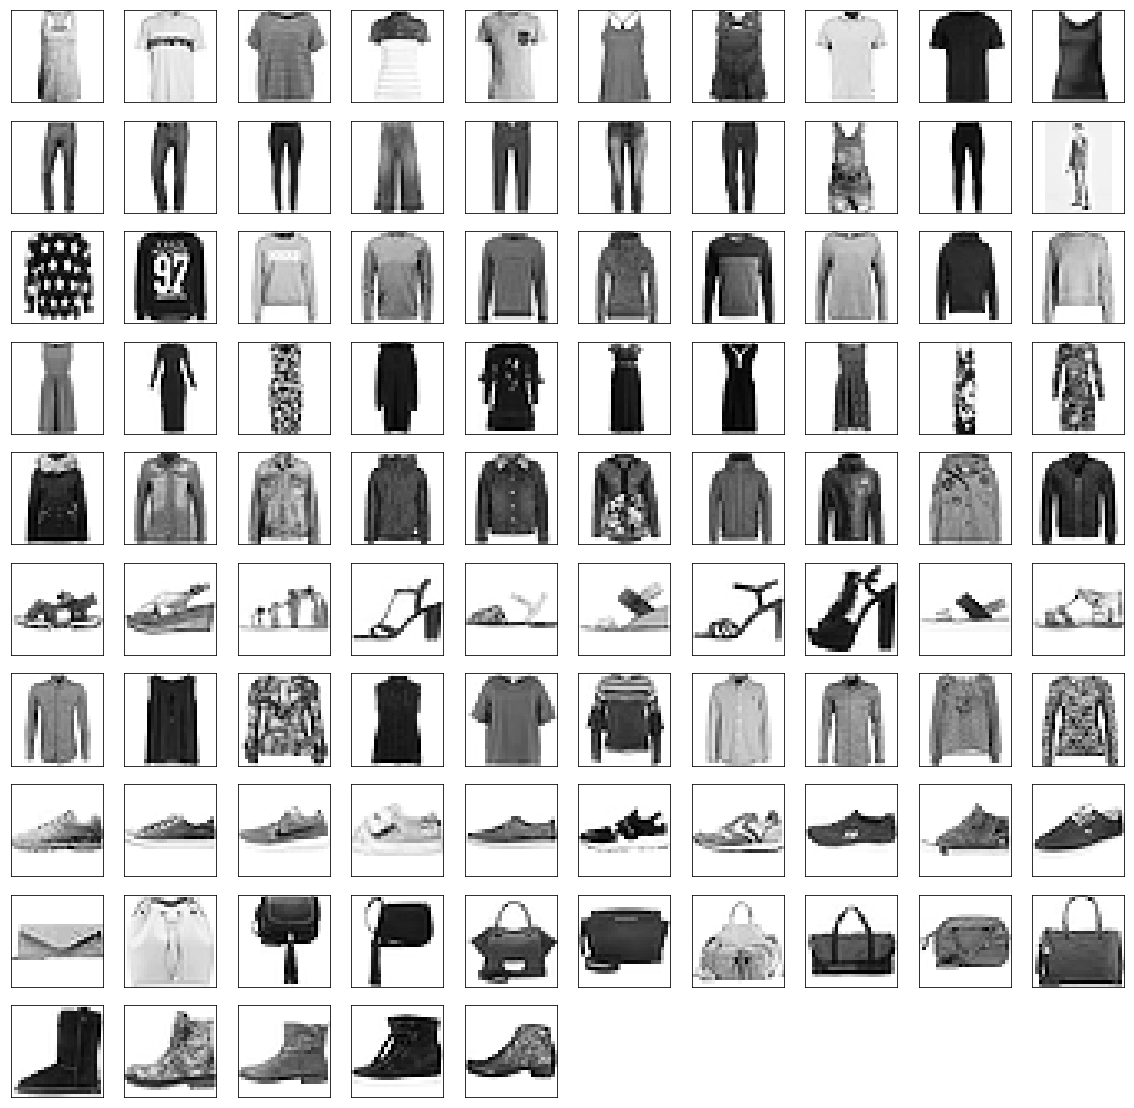

In [10]:
# Extract n random samples of each class from the dataset
def get_random_sample(number_of_samples=10):
    x = []
    y = []
    for category_number in range(0,10):
        # get all samples of a category
        train_data_category = train_data[train_labels==category_number]
        # pick a number of random samples from the category
        train_data_category = train_data_category[np.random.randint(train_data_category.shape[0], 
                                                                    size=number_of_samples), :]
        x.extend(train_data_category)
        y.append([category_number]*number_of_samples)
    
    return np.asarray(x).reshape(-1, 28, 28, 1), y
   
x_ten_samples, y_ten_samples = get_random_sample(number_of_samples=10)

y_ten_samples = to_categorical(y_ten_samples)
    
print(np.shape(x_ten_samples))
print(np.shape(y_ten_samples))
plot_images(x_ten_samples[0:100], rows=10, figsize=(20,20))

These are a hundred examples for our training data. Each row is one category with ten examples. 

| Label | Description |
| :---: |:-----------:|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Can you tell apart every coat from a pullover? I certainly can't.
But lets see if a small convolutional neural net can.

## Model

Our model will consist of just two stacks of two convolution layers each. Each layer has a ReLU activation. After each stack we put a max-pooling layer.

On top of these convolution layers we put two fully connected layers. The last layer gets one unit per category, as it has to decide in which category each image belongs. 
As loss function we use `categorical_crossentropy` to train our model. 

After compiling the model, we can see that is has a total of 126,122 parameters that can be used for training.

In [ ]:
def getModel():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
    model.add(Conv2D(filters = 32, kernel_size = (2, 2), activation='relu'))
    model.add(MaxPool2D(strides=(2,2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
    model.add(MaxPool2D(strides=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=["accuracy"])
    
    
    return model
print(getModel().summary())

## Baseline with full data

To see how our tests with smaller datasets perform in comparison with the full original dataset we first need to to establish a baseline.

For that we transform all of our data to a format that tensorflow can understand: The first dimension are the individual training images and the second and third dimensions are the x- and y-axis of the individual image. The fourth dimension would consist of the different color channels, but we currently working with only one since we only work with grayscale images here.

In [ ]:
# reshape the images to 4D tensors
x_train_data = train_data.reshape(-1, 28, 28, 1)
y_train_data = to_categorical(train_labels)

print(np.shape(x_train_data))
print(np.shape(y_train_data))

x_test_data = test_data.reshape(-1, 28, 28, 1)
y_test_data = to_categorical(test_labels)
print(np.shape(x_test_data))
print(np.shape(y_test_data))


In [ ]:
number_of_epochs = 30

We set the number of epochs to 30. On a okayish laptop that will take 30 minutes to run. If you have a better machine feel free to increase the number of epochs and see what happens. 

Now we train the model on our complete training data and use the whole test data as validation. For nicer visualization of the training progress we add the `TQDMNotebookCallback` to the callback list.

In [ ]:
model_original_data = getModel()

hist_original_data = model_original_data.fit(x_train_data,
                     y_train_data,
                     epochs=number_of_epochs,
                     verbose=0,
                     callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                     validation_data=(x_test_data, y_test_data),
                     shuffle=True
                )

print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist_original_data.history['val_loss'][-1], 
    hist_original_data.history['val_acc'][-1]))

`Final loss: 0.5469, final accuracy: 0.9093` after 30 epochs.

Now we have a baseline against which we can compare our augmented data.

## Creating training data with augmentation

Augmentation of image datasets is really easy with with the `keras.preprocessing.image.ImageDataGenerator` class. 

With the `ImageDataGenerator` you can apply random transformations to a given set of images. By this you can effectively increase the number of images you can use for training.

What makes the `ImageDataGenerator` extra convinient is that we can use it as direct input to the `model.fit()` function without generating and saving a bunch of images first.

Lets take a closer look at the transformations you can apply:

### Transformations

Lets take just one image first to see what the transformers do to it. We can use all of these transformers via the `ImageDataGenerator` or on their own if we want to.

In [ ]:
img = x_train_data[0]
plot_images([img])

### Shift
`random_shift` allows you to randomly shift by a given fraction of the imagesize in each direction. 
Here we specify `wrg=0.1` and `hrg=0.2`. That means that we shift up to 0.2 x imagesize (0.2 x 28 = 5.6) pixel up or down and up to 0.1 x imagesize (0.1 x 28 = 2.8) pixel left or right.

In all transformer functions you can specify `row_axis`, `col_axis` and `channel_axis` according to the array of images you pass into the function.

Also you can specify the a `fill_mode` for pixel values that are not originally in the image. For instance if we shift up an image by 3 pixels we need to fill the new 3 rows of pixels with some value.

To illustrate the different values of `fill_mode` I will use the following example image: ![1234](outsvg00.svg)

You can set `fill_mode` to one the following values:
- `constant`: Fill the missing values with a constant value. You can specify the constant value with the option `cval`. Otherwise `0` will be used. 
    Example:  With `cval`=5 ![55555555 |1234| 55555555](outsvg01.svg)

- `nearest`: The nearest non-empty pixel value is used.
    Example: ![11111111 |1234| 44444444](outsvg02.svg)
    

    
    
- `reflect`: The image is reflected on the original image border and the values are filled in accordingly.
    Example: ![12344321 |1234| 43211234](outsvg03.svg)

- `wrap`:  The original image is repeated multiple times for the empty pixels.
    Example: ![12341234 |1234| 12341234](outsvg04.svg)

In this post we will use the fill mode `constant` with the default `cval` of `0` since the objects in the images are surronded by white empty space. If your images look different and have color in them you should either choose another `cval` or a different `fill_mode`.

In [ ]:
img_shifted = [ random_shift(
    img, 
    wrg=0.1, 
    hrg=0.2, 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_shifted)

### Rotation

With the `random_rotation` transformer we can rotate the image randomly by up to x degrees clockwise or counterclockwise. Here we specify a maximum rotation of 20 degrees.

In [ ]:
img_rotated = [ random_rotation(
    img, 
    20, 
    row_axis=0, 
    col_axis=1, 
    channel_axis=2, 
        fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_rotated)

### Shear

The `random_shear` functions [shears](https://en.wikipedia.org/wiki/Shear_mapping) an image with a random shearing angle that is calculated from the given `intensity. 

Note that shearing is different from just rotation since it deforms the given image by multiplying it with the following transformation matrix:

$
\begin{pmatrix}
1 & -sin(m) & 0 \\
0 & cos(m) & 0 \\
0 & 0 & 1 
\end{pmatrix}
$

Where $m$ is $x * \pi / 180$ with $x$ being a random float in $[- intensity, +intensity]$.

In [ ]:
img_sheared = [ random_shear(
    img,
    intensity=0.5,
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_sheared)

### Zoom

`random_zoom` zooms in and out of an image. But it don't use the same zooming factor for horizontal and vertical zoom but two independently random values. We can specify a minimum (here 0.7) and a maximum value (here 1.3) for the zoom. A value bigger than 1.0 zooms in, thus making the object in the image bigger. A value smaller than 1.0 zooms out.

In [ ]:
img_zoomed = [ random_zoom(
    img,
    zoom_range=(0.7,1.3),
    row_axis=0,
    col_axis=1,
    channel_axis=2,
    fill_mode='constant',
    cval=0
) for _ in range(5) ]
plot_images(img_zoomed)

### Combined in the `ImageDataGenerator`

Now we combine every transformation that we just did in one `ImageDataGenerator`. It is also possibly to allow a flip of the image either horizontally or vertically. For now we disallow that option. 

When we start the `ImageDataGenerator` it runs in an endless loop. But since we just want a few example we let it run in a `for` loop and break out of it when we have collected enough examples.

This allows us to create 100 images from just one image.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False, 
        fill_mode='constant',
        cval=0
)
batches = 0
max_batches = 100
img_gen = []
for x_batch in datagen.flow(img.reshape((1,) + img.shape), batch_size=max_batches):
    img_gen.append(x_batch[0])
    batches += 1
    if batches >= max_batches:
        # generator loops indefinetly
        break
        
plot_images(img_gen, rows=10, figsize=(20,16))

## Training with augmented datasets

To test the effectiveness of the augmentation of our dataset we will try to train our model on randomly sampled training sets of different sizes. We will use 1, 10, 100 and 1000 examples per class and train with each reduced dataset for 30 epochs.

For this we first define a image generator like above.

In [ ]:
gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='constant',
        cval=0
)

Now we define a function that will train a model with a specified number of samples per category: 
First, we randomly pick a number of samples from each category from the original training dataset with the function we defined earlier. 

Then we feed this small sample of training data into the `ImageDataGenerator` and initialize it. We define a batchsize of 30 which means that the generator will generate 30 randomly transformed on each call. 

We create a new Model of the same structure as we defined it earlier for the original training data.

Finally we train the model on data from the generator with the `fit_generator()` function instead of the "standard" `fit()`. We choose 2000 steps per epoch to get a total of 30 x 2000 = 60,000 training examples like in the original training dataset. But instead of the 60,000 totally different images we now have images that are generated from a much, much smaller set of images.

In [ ]:
def train_on_x_samples(samples, batchsize=30, steps=2000):
    # Get training data
    x_n_samples, y_n_samples = get_random_sample(number_of_samples=samples)
    y_n_samples = to_categorical(y_n_samples)
    
    # Put data in generator
    train_generator_n_samples = gen.flow(x_n_samples, 
                            y_n_samples, 
                            batch_size=batchsize,
                            seed=random_seed)
    
    model_n_samples = getModel()

    hist_n_samples = model_n_samples.fit_generator(
                train_generator_n_samples,
                steps_per_epoch=steps,
                epochs=number_of_epochs,
                verbose=0,
                callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                validation_data=(x_test_data, y_test_data),
                shuffle=True
    )
    return hist_n_samples

Now lets test our model with a bunch of examples.

### One sample per category

In [ ]:
hist_one_sample = train_on_x_samples(1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist_one_sample.history['val_loss'][-1], 
    hist_one_sample.history['val_acc'][-1]))

Outcome: Final loss: 9.7327, final accuracy: 0.3099

### Ten samples per category

In [ ]:
hist_ten_samples = train_on_x_samples(10)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist_ten_samples.history['val_loss'][-1], 
    hist_ten_samples.history['val_acc'][-1]))

Outcome: Final loss: 3.8454, final accuracy: 0.6774

### Hundred samples per category

In [ ]:
hist_hundred_samples = train_on_x_samples(100)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist_hundred_samples.history['val_loss'][-1], 
    hist_hundred_samples.history['val_acc'][-1]))

Outcome: Final loss: 1.4771, final accuracy: 0.8161

### Thousand samples per category

In [ ]:
hist_thousand_samples = train_on_x_samples(1000)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist_thousand_samples.history['val_loss'][-1], 
    hist_thousand_samples.history['val_acc'][-1]))

Outcome: Final loss: 0.3742, final accuracy: 0.8896

## Results
Now we have tested with different datasets of increasing sizes.
Lets plot the results for training and validation accuracy:


In [ ]:
figure = plt.figure(figsize=(20,9))

subplot = figure.add_subplot(1, 2, 1)

plt.plot(hist_original_data.history['acc'], color='#ff3d00', label='Original data')
plt.plot(hist_one_sample.history['acc'], color='#a7c0cd', label='1 sample')
plt.plot(hist_ten_samples.history['acc'], color='#78909c', label='10 samples')
plt.plot(hist_hundred_samples.history['acc'], color='#4b636e', label='100 samples')
plt.plot(hist_thousand_samples.history['acc'], color='#37474f', label='1000 samples')
plt.ylim(0.0,1.09)

tick_marks = np.arange(number_of_epochs)
plt.xticks(tick_marks, range(number_of_epochs), rotation=45)
plt.title("Training accuracy", fontsize=13, 
             fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')


subplot = figure.add_subplot(1, 2, 2)
plt.plot(hist_original_data.history['val_acc'], color='#ff3d00', label='Original data')
plt.plot(hist_one_sample.history['val_acc'], color='#a7c0cd', label='1 sample')
plt.plot(hist_ten_samples.history['val_acc'], color='#78909c', label='10 samples')
plt.plot(hist_hundred_samples.history['val_acc'], color='#4b636e', label='100 samples')
plt.plot(hist_thousand_samples.history['val_acc'], color='#37474f', label='1000 samples')
plt.ylim(0.0,1.09)

tick_marks = np.arange(number_of_epochs)
plt.xticks(tick_marks, range(number_of_epochs), rotation=45)
plt.title("Validation accuracy", fontsize=13, 
             fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')



plt.show()



After training the model with the given number of training samples for 30 epochs we reach the following final accuracies: 

| Number of samples per category | Accuracy |
| :----------------------------: |:--------:|
| 6000 (original dataset)        | 0.9093   |
| 1000                           | 0.8896   |
| 100                            | 0.8161   |
| 10                             | 0.6774   |
| 1                              | 0.3099   |


While it is still true that more data leads to better results we can reach about 81% accuracy with just two percent of the original dataset when we use an image generator to augment our small test datasets. 

Smaller training data sets lead to stronger overfitting problems, as we can see in the high training accuracy but low validation accuracy. Data augmentation is one way to mitigate this problem. We could adapt other methods such as dropouts and regularization to further improve our results.

There are also other possible solutions to working with small datasets. You could, for example, retrain an available and already trained network to fit your specific usecase (this is something I will demonstrate in an upcoming post).

In this post I showed you how you can use the Keras `ImageDataGenerator` to augment small image datasets really easily and efficently. The full Jupyter notebook with all the code that was produced in this post is available at [Github]().
Did you use the `ImageDataGenerator` in one of your projects? Did you even came up with your own augmentation method for image data? Please let me know.
